# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


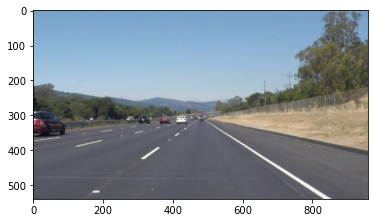

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [17]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None or not (len(lines) > 0):
        return
    old_version = False #True
    
    # Initialize values
    shared_lane_top_y = img.shape[0]
    
    right_lane_bucket = []    
    right_lane_slope_sum = 0
    right_lane_y_offset_sum = 0
    
    left_lane_bucket = []    
    left_lane_slope_sum = 0
    left_lane_y_offset_sum = 0
    
    for line in lines:        
        for x1,y1,x2,y2 in line:
            if old_version:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                continue
            
            slope = (y2-y1)/(x2-x1)
            # Filter non relevant lanes
            if (-.4 < slope and slope < .4) or slope < -0.90 or slope > 0.90:
                #print("Discarding line slope: {}".format(slope))
                continue
            
            # Assign line to left or right lane
            if (slope) > 0:
                # Right lane
                right_lane_bucket.append(line)
                # Determine highest Y                
                if y1 < shared_lane_top_y:
                    shared_lane_top_y = y1
                    #print("New lane top y: {}".format(y1))
                right_lane_slope_sum += slope
                #print("Adding slope: {}".format(slope))
                right_lane_y_offset_sum += y1 - x1*slope
                #print("Adding offset: {}".format(right_lane_y_offset_sum))
               
            else:
                # Left lane
                left_lane_bucket.append(line)
                # Determine highest Y                
                if y1 < shared_lane_top_y:
                    shared_lane_top_y = y1
                    #print("New left lane top y: {}".format(y1))
                left_lane_slope_sum += slope
                #print("Adding slope: {}".format(slope))
                left_lane_y_offset_sum += y1 - x1*slope
                #print("Adding offset: {}".format(left_lane_y_offset_sum))
        
    if not old_version:
        if(len(right_lane_bucket) > 0):
            #print("Right bucket len: {}".format(len(right_lane_bucket)))
            right_lane_slope_avg = right_lane_slope_sum / len(right_lane_bucket)
            #print("Right slope avg: {}".format(right_lane_slope_avg))
            right_lane_y_offset_avg = right_lane_y_offset_sum / len(right_lane_bucket)
            #print("Right offset avg: {}".format(right_lane_y_offset_avg))

            y1 = int(shared_lane_top_y)
            x1 = int(calc_x(y1, right_lane_slope_avg, right_lane_y_offset_avg))
            y2 = int(img.shape[0])
            x2 = int(calc_x(y2, right_lane_slope_avg, right_lane_y_offset_avg))

            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
        if(len(left_lane_bucket) > 0):
            #print("Left bucket len: {}".format(len(right_lane_bucket)))
            left_lane_slope_avg = left_lane_slope_sum / len(left_lane_bucket)
            #print("Left slope avg: {}".format(left_lane_slope_avg))
            left_lane_y_offset_avg = left_lane_y_offset_sum / len(left_lane_bucket)
            #print("Left offset avg: {}".format(left_lane_y_offset_avg))

            y1 = int(shared_lane_top_y)
            print("{} {} {}".format(y1, left_lane_slope_avg, left_lane_y_offset_avg))
            x1 = int(calc_x(y1, left_lane_slope_avg, left_lane_y_offset_avg))
            y2 = int(img.shape[0])
            x2 = int(calc_x(y2, left_lane_slope_avg, left_lane_y_offset_avg))

            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
def calc_x(y, a, b):
    return (y - b)/a

def calc_y(x, a, b):
    return a*x + b

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")    

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

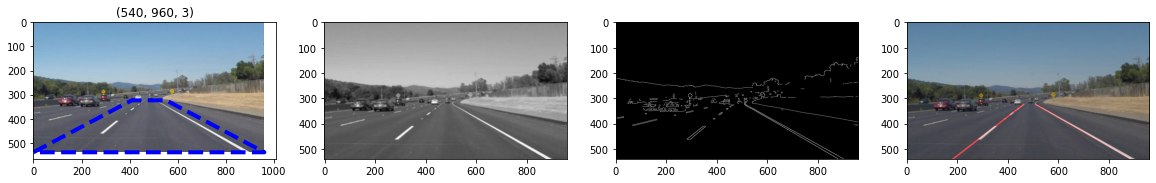

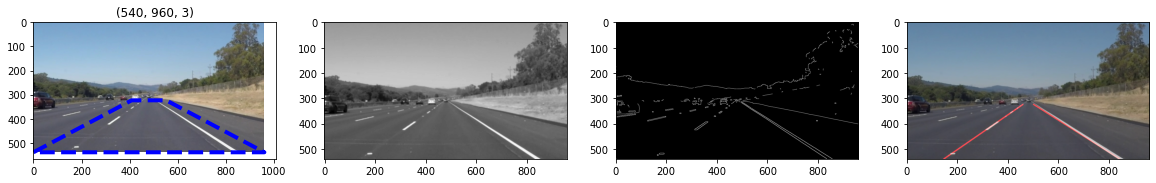

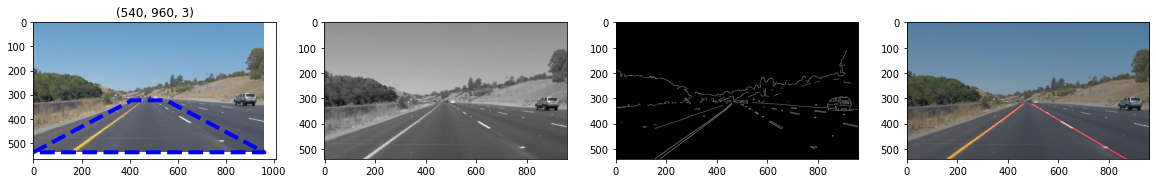

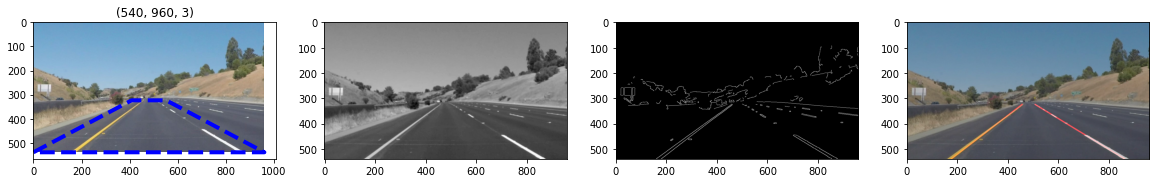

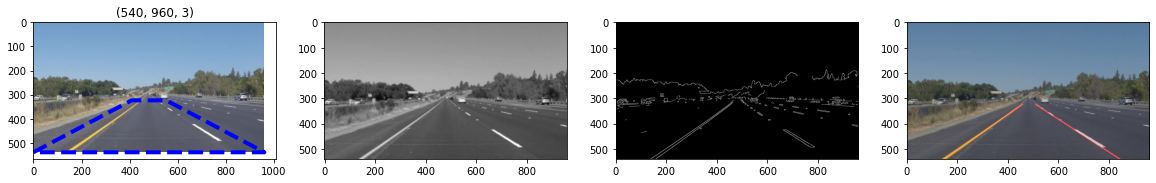

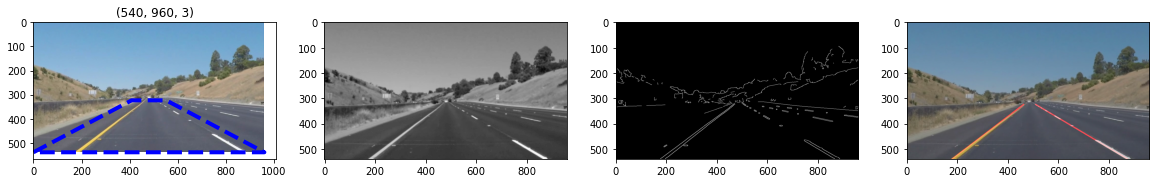

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def process_and_display_img(img_dir, img_file):
    img_path = "test_images/" + img_file
    initial_img = mpimg.imread(img_path)
    gray = grayscale(initial_img)
    blur_gray = gaussian_blur(gray, kernel_size=5)
    
    #initial_img_hsv = cv2.cvtColor(initial_img, cv2.COLOR_RGB2HSV)
    #blur_gray = gaussian_blur(initial_img_hsv[:,:,2], kernel_size=5)
    
    # Create a masked edges image using canny
    edges = canny(blur_gray, low_threshold=100, high_threshold=150)    
    
    # Define a four sided polygon to mask
    # Quadrilatere top size
    apex_width = initial_img.shape[1]*0.15
    apex_y = initial_img.shape[0]*0.60
    
    left_bottom = [0, initial_img.shape[0]]
    right_bottom = [initial_img.shape[1], initial_img.shape[0]]
    left_top = [(initial_img.shape[1]-apex_width)/2, apex_y]
    right_top = [(initial_img.shape[1]+apex_width)/2, apex_y]
    
    vertices=np.array(
        [[
            (left_bottom[0],left_bottom[1]),
            (left_top[0],left_top[1]), 
            (right_top[0],right_top[1]),
            (right_bottom[0],right_bottom[1])
        ]],
        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Apply a Hough transform to get the lines
    line_img = hough_lines(masked_edges, rho=2, theta=np.pi/180, threshold=15, min_line_len=30, max_line_gap=20)
    
    # Draw the lines on the image
    img_weighted = weighted_img(line_img, initial_img, α=0.8, β=1., γ=0.)
    
    # Uncomment for processed image display
    #f, (ax1) = plt.subplots(1, 1, figsize=(30,10))
    #ax1.imshow(img_weighted)
    #plt.show()
    
    cv2.imwrite('test_images_processed/{}'.format(img_file), cv2.cvtColor(img_weighted, cv2.COLOR_RGBA2BGRA), [cv2.IMWRITE_JPEG_QUALITY, 100])
    
    # Uncomment for process steps display
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))    
    
    # Uncomment for process steps and HSV image display
    #f, ((ax1, ax2, ax3, ax4), (ax21, ax22, ax23, ax24)) = plt.subplots(2, 4, figsize=(20,5))
    
    ax1.imshow(initial_img)
    ax1.set_title(initial_img.shape)
    x = [left_bottom[0], left_top[0], right_top[0], right_bottom[0], left_bottom[0]]
    y = [left_bottom[1], left_top[1], right_top[1], right_bottom[1], left_bottom[1]]
    ax1.plot(x, y, 'b--', lw=4)
    ax2.imshow(blur_gray, cmap='gray')
    ax3.imshow(edges, cmap='gray')
    ax4.imshow(img_weighted)
            
    #initial_img_hsv = cv2.cvtColor(initial_img, cv2.COLOR_RGB2HSV)
    #ax21.imshow(initial_img_hsv)
    #ax22.imshow(initial_img_hsv[:,:,0], cmap='gray')
    #ax23.imshow(initial_img_hsv[:,:,1], cmap='gray')
    #ax24.imshow(initial_img_hsv[:,:,2], cmap='gray')
    
    #plt.show()    
    
for img_file in os.listdir("test_images/"):
    if os.path.isfile(("test_images/{}".format(img_file))):
        process_and_display_img("test_images/", img_file)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size=5)
    
    #initial_img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #blur_gray = gaussian_blur(initial_img_hsv[:,:,2], kernel_size=5)    
    
    # Create a masked edges image using canny
    edges = canny(blur_gray, low_threshold=50, high_threshold=150)    
    
    # Define a four sided polygon to mask
    # Quadrilatere top size
    apex_width = image.shape[1]*0.15
    apex_y = image.shape[0]*0.60
    
    left_bottom = [0, image.shape[0]]
    right_bottom = [image.shape[1], image.shape[0]]
    left_top = [(image.shape[1]-apex_width)/2, apex_y]
    right_top = [(image.shape[1]+apex_width)/2, apex_y]
    
    vertices=np.array(
        [[
            (left_bottom[0],left_bottom[1]),
            (left_top[0],left_top[1]), 
            (right_top[0],right_top[1]),
            (right_bottom[0],right_bottom[1])
        ]],
        dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # Apply a Hough transform to get the lines
    line_img = hough_lines(masked_edges, rho=2, theta=np.pi/180, threshold=15, min_line_len=30, max_line_gap=20)
    
    # Draw the lines on the image
    return weighted_img(line_img, image, α=0.8, β=1., γ=0.)   


Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 2/221 [00:00<00:11, 19.42it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 6.06 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 3/681 [00:00<00:26, 25.21it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 17.8 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(3,7)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

                                                             
                                                          

t:  16%|█▌        | 16/100 [08:51<00:03, 25.22it/s, now=None]

                                                             
                                                          

t:  16%|█▌        | 16/100 [08:51<00:03, 25.22it/s, now=None]

t:  16%|█▌        | 16/100 [05:02<00:03, 26.00it/s, now=None]


t:   0%|          | 0/100 [00:00<?, ?it/s, now=None]


t:   2%|▏         | 2/100 [00:00<00:05, 16.81it/s, now=None]

451 -0.7092989476541268 889.9845289165461
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

451 -0.7092989476541268 889.9845289165461
451 -0.729325097594077 903.237511514746




t:   5%|▌         | 5/100 [00:00<00:05, 18.78it/s, now=None]


t:   8%|▊         | 8/100 [00:00<00:04, 21.02it/s, now=None]


432 -0.7259963625999529 899.4878254192638
451 -0.7042477008853064 890.9907593779067
452 -0.7409982425450568 908.8756049643828
454 -0.7349917088602004 902.1004037397242
453 -0.7031878694561571 873.638010168323
434 -0.6375769999243536 846.6332215417051




t:  11%|█         | 11/100 [00:00<00:03, 22.37it/s, now=None]


447 -0.749447156998136 908.5794047054411
459 -0.7386330311537761 902.0016544911655
458 -0.7476983150088081 911.4299435754002
449 -0.7013459834713143 886.1502394717246
476 -0.7052866413979969 878.2358573944352





t:  15%|█▌        | 15/100 [00:00<00:03, 24.87it/s, now=None]


t:  19%|█▉        | 19/100 [00:00<00:03, 26.59it/s, now=None]

463 -0.6428438755455791 820.3258602364575
474 -0.6375543794966892 812.8636545460716
467 -0.5487062464445049 784.6586876922684
503 -0.6063138696538822 799.2814072285947
508 -0.8145431326510544 946.3915190027701
512 -0.6239343777115207 811.9752250275607
436 -0.6963905381203142 856.0821018075072




t:  23%|██▎       | 23/100 [00:00<00:02, 28.13it/s, now=None]


436 -0.6070173845915029 830.2037389689514
432 -0.7061571216087335 866.2225895762234
528 -0.6378223292262711 816.9036738371132
436 -0.7594460951350317 898.086673047159
436 -0.7406250066671479 880.0128017984246
485 -0.74622083963721 896.6120046206441





t:  27%|██▋       | 27/100 [00:00<00:02, 29.84it/s, now=None]


t:  31%|███       | 31/100 [00:01<00:02, 31.17it/s, now=None]

476 -0.7597237056334636 919.0522534026434
432 -0.7860324770022722 924.0925933919168
451 -0.755808926884594 910.6284231382613
475 -0.6422939528958146 858.732143466993
434 -0.649209173612151 878.6283641796324
561 -0.8823529411764706 983.7058823529412
527 -0.5333333333333333 894.7333333333333
434 -0.6128245180664535 902.9169027898866




t:  35%|███▌      | 35/100 [00:01<00:01, 32.57it/s, now=None]


t:  39%|███▉      | 39/100 [00:01<00:01, 33.79it/s, now=None]


557 -0.715427927927928 966.7198198198199
577 -0.791493583663145 907.6847109104983
621 -0.7145561622163914 867.6339720957452
481 -0.6570827939665969 862.571275311152
483 -0.6967295749230829 860.2361724717341
433 -0.6948042079706085 856.9513865078522





t:  43%|████▎     | 43/100 [00:01<00:01, 34.70it/s, now=None]


t:  47%|████▋     | 47/100 [00:01<00:01, 34.55it/s, now=None]

438 -0.8 903.6
443 -0.6452155394220457 847.252734154613
455 -0.692714126807564 866.0141824249166
445 -0.671758395522388 847.7529151119403
552 -0.5666666666666667 778.6





t:  51%|█████     | 51/100 [00:01<00:01, 25.20it/s, now=None]


t:  54%|█████▍    | 54/100 [00:01<00:01, 26.19it/s, now=None]

432 -0.6809505853623501 850.3540573152338
486 -0.6938775510204082 857.469387755102
496 -0.6040875467093724 818.7017463585754
439 -0.4 694.4
460 -0.5 756.0





t:  57%|█████▋    | 57/100 [00:01<00:01, 26.79it/s, now=None]


t:  60%|██████    | 60/100 [00:02<00:01, 27.45it/s, now=None]

519 -0.6964285714285714 860.1428571428571
440 -0.6462339993936607 843.4649240794314
446 -0.5270448148762008 757.9449020987333
442 -0.6106744637577458 818.4517524316122
454 -0.5829751476039132 794.8543197441671
454 -0.5557027966365771 783.4359791540408




t:  63%|██████▎   | 63/100 [00:02<00:01, 26.67it/s, now=None]


457 -0.5751917113653683 797.0876377650557
470 -0.6250886524822695 829.3040780141844
459 -0.5331497067007164 788.9166182764792





t:  66%|██████▌   | 66/100 [00:02<00:01, 18.67it/s, now=None]

454 -0.6548022111602261 836.1050654804737
454 -0.5445515595114226 789.0469066469664
454 -0.6072674823875347 828.4271488423075
468 -0.550074074074074 786.8038518518518
463 -0.5753910190051494 834.1642437423686





t:  69%|██████▉   | 69/100 [00:02<00:01, 17.58it/s, now=None]


t:  72%|███████▏  | 72/100 [00:02<00:01, 17.85it/s, now=None]

460 -0.584976118845925 832.532153959359
470 -0.550288778741668 849.0242705764545
500 -0.559855928450709 815.4259166605239
463 -0.5626555382470241 787.9313607276381





t:  75%|███████▌  | 75/100 [00:02<00:01, 19.04it/s, now=None]


t:  78%|███████▊  | 78/100 [00:03<00:01, 20.55it/s, now=None]

482 -0.5516111817118827 812.408247571466
453 -0.561051859834843 810.6087128928816
452 -0.6195119762966945 819.3251443265574
491 -0.5709619318782175 808.3746709616382
455 -0.5662069868495048 796.8493028906887
445 -0.5829213533542239 811.5300456917568
445 -0.5465251071384187 789.9161267148794
441 -0.5232149005190864 767.765615273981




t:  81%|████████  | 81/100 [00:03<00:01, 16.79it/s, now=None]


t:  84%|████████▍ | 84/100 [00:03<00:00, 18.94it/s, now=None]


448 -0.5365994962887294 782.3447518074994
452 -0.5713302969580083 798.921936472928
443 -0.5885031044879341 803.3153506078486
439 -0.5739423140548402 796.1984888962838





t:  87%|████████▋ | 87/100 [00:03<00:00, 21.16it/s, now=None]


t:  90%|█████████ | 90/100 [00:03<00:00, 21.75it/s, now=None]

442 -0.566981563700206 788.6212889652761
447 -0.5742608726768637 797.1699399775106
445 -0.5771688859315167 796.6624876157413
447 -0.5744163982636111 794.5957859391624
445 -0.5708952537505255 797.5624736551509
451 -0.5650149458955108 802.8101814583273
448 -0.5529745396140051 799.1332252306952





t:  93%|█████████▎| 93/100 [00:04<00:00, 14.41it/s, now=None]


t:  96%|█████████▌| 96/100 [00:04<00:00, 16.84it/s, now=None]

432 -0.5531216551432613 794.6661072895339
454 -0.5248830696716907 784.052766576347
452 -0.5829297355387646 819.0699099937785
455 -0.5771752657021758 815.7231398549806
457 -0.6089080272209527 831.2247873824223





t:  99%|█████████▉| 99/100 [00:04<00:00, 17.53it/s, now=None]


                                                             

459 -0.6416463049367654 853.3605393343539
451 -0.5990709735859624 824.9336324573545
453 -0.6297812701509408 842.220635447675
447 -0.6200823839262812 833.7230347705868


                                                             
                                                          

t:  16%|█▌        | 16/100 [08:58<00:03, 25.22it/s, now=None]

                                                             
                                                          

t:  16%|█▌        | 16/100 [08:58<00:03, 25.22it/s, now=None]

t:  16%|█▌        | 16/100 [05:08<00:03, 26.00it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 6.27 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))